# AULA 02 - PLANEJAMENTO DE SISTEMAS ELÉTRICOS

## PPEE - UFJF



## Dados do Problema

UHE, UTE e Dados Gerais

In [ ]:
lista_uhe = []
lista_ute = []

usina = {
    "Nome": "UHE DO MARCATO",
    "Vmax": 100.,
    "Vmin": 20.,
    "Prod": 0.95,
    "Engol": 60.,
    "Afl": [
            [23,16],
            [19,14],
            [15,11]
    ]
}

lista_uhe.append(usina)

usina = {
    "Nome": "UHE DO MENGAO",
    "Vmax": 200.,
    "Vmin": 40.,
    "Prod": 0.85,
    "Engol": 100.,
    "Afl": [
            [46,32],
            [38,28],
            [30,22]
    ]
}

#lista_uhe.append(usina)

usina = {
    "Nome": "GT_1",
    "Capac": 15.,
    "Custo": 10.
}

lista_ute.append(usina)

usina = {
    "Nome": "GT_2",
    "Capac": 10.,
    "Custo": 25.
}

lista_ute.append(usina)

dgerais = {
    "CDef": 500.,
    #"Carga": [100,100.,100.],
    "Carga": [50,50.,50.],
    "Nr_Disc": 12,
    "Nr_Est": 3,
    "Nr_Cen": 2
}

sistema = {
    "DGer": dgerais,
    "UHE": lista_uhe,
    "UTE": lista_ute
}

print(sistema["UTE"][0]["Nome"])

GT_1


## Modelo de Otimização

Criação de uma função para o despacho hidrotérmico

$Min \hspace{0.5 cm} C_1 \cdot gt_1 + C_2 \cdot gt_2 + CDEF \cdot def + 0.01 \cdot vvert$

Sujeito a:

$vf = VI + AFL - vtur - vvert$ (Equação de balanço hídrico)

$\rho \cdot vtur + gt_1 + gt_2 + def = CARGA$ (Equação de atendimento à demanda)

$20 \le vf \le 100$

$0 \le vtur \le 60$

$0 \le vvert \le \infty$

$0 \le gt_1 \le 15$

$0 \le gt_2 \le 10$

$0 \le def \le \infty$


# RESOLVENDO O PROBLEMA DE OTIMIZACAO

In [ ]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op

def despacho(sistema, VI, AFL, pote_de_corte, iest, imprime):

  Num_UHE = len(sistema["UHE"])

  Num_UTE = len(sistema["UTE"])

  vf = variable(Num_UHE, "Volume final da usina")
  vt = variable(Num_UHE, "Volume turbinado da usina")
  vv = variable(Num_UHE, "Volume vertido da usina")

  gt = variable(Num_UTE, "Geracao na UTE")
  deficit = variable(1, "Deficit de energia no sist")

  alpha = variable(1,"Custo Futuro")

  # Construcao da f obj

  fob = 0

  for i,iusi in enumerate(sistema["UTE"]):
    fob += iusi["Custo"]*gt[i]

  fob += sistema["DGer"]["CDef"]*deficit[0]

  for i,iusi in enumerate(sistema["UHE"]):
    fob += 0.01*vv[i]

  fob += 1.0*alpha[0]

  #Def das restricoes

  restricoes = []

  #balanco hidrico
  for i,iusi in enumerate(sistema["UHE"]):
    restricoes.append( vf[i] == float(VI[i]) + float(AFL[i]) - vt[i] - vv[i])

  # atendimento a demanda

  AD = 0

  for i,iusi in enumerate(sistema["UHE"]):
    AD += iusi["Prod"]*vt[i]

  for i,iusi in enumerate(sistema["UTE"]):
    AD += gt[i]

  AD += deficit[0]

  restricoes.append(AD == sistema["DGer"]["Carga"][iest-2])

  # Restricoes de canalizacao

  for i,iusi in enumerate(sistema["UHE"]):
    restricoes.append( vf[i] >= iusi["Vmin"])
    restricoes.append( vf[i] <= iusi["Vmax"])
    restricoes.append( vt[i] >= 0)
    restricoes.append( vt[i] <= iusi["Engol"])
    restricoes.append( vv[i] >= 0)

  for i,iusi in enumerate(sistema["UTE"]):
    restricoes.append( gt[i] >= 0)
    restricoes.append( gt[i] <= iusi["Capac"])

  restricoes.append(deficit[0] >= 0)

  restricoes.append(alpha[0] >= 0)

  for icorte in pote_de_corte:
    if icorte["Estagio"]==iest:
      equacao = 0
      for iusi in range(Num_UHE):
        equacao += float(icorte["Coefs"][iusi])*vf[iusi]
      equacao += float(icorte["Termo_Indep"])
      restricoes.append(alpha[0] >= equacao)

  problema = op(fob,restricoes)

  problema.solve('dense','glpk')

  Dger = {
      "Deficit": deficit[0].value()[0],
      "CMO": restricoes[Num_UHE].multiplier.value[0],
      "Custo total": fob.value()[0],
      "Custo futuro": alpha[0].value()[0]
  }

  lista_uhe = []

  for i, iusi in enumerate(sistema["UHE"]):
    resultado = {
        "vf": vf[i].value()[0],
        "vt": vt[i].value()[0],
        "vv": vv[i].value()[0],
        "cma": restricoes[i].multiplier.value[0]
    }
    lista_uhe.append(resultado)

  lista_ute = []

  for i, iusi in enumerate(sistema["UTE"]):
    resultado = {
        "gt": gt[i].value()[0]
    }
    lista_ute.append(resultado)

  resultado = {
      "DGer": Dger,
      "UHE": lista_uhe,
      "UTE": lista_ute
  }

  if imprime:
    print("Custo total:",fob.value())

    for i,iusi in enumerate(sistema["UHE"]):
      print(vf.name,i,"é",vf[i].value(),"hm3")
      print(vt.name,i,"é",vt[i].value(),"hm3")
      print(vv.name,i,"é",vv[i].value(),"hm3")

    for i,iusi in enumerate(sistema["UTE"]):
      print(gt.name,i,"é",gt[i].value(),"MWmed")

    print(deficit.name,"é",deficit[0].value(),"MWmed")

    print(alpha.name,"é",alpha[0].value(),"R$")

    for i,iusi in enumerate(sistema["UHE"]):
      print("O valor da água na usina",i,"é",restricoes[i].multiplier.value)

    print("O Custo Marginal de Operacao é",restricoes[Num_UHE].multiplier.value, "R$/MWh")
    print("\n###########################################################\n")

  return(resultado)

Custo total: [ 9.97e+02]

Volume final da usina 0 é [ 5.17e+01]
 hm3
Volume turbinado da usina 0 é [ 2.63e+01]
 hm3
Volume vertido da usina 0 é [ 0.00e+00]
 hm3
Geracao na UTE 0 é [ 1.50e+01]
 MWmed
Geracao na UTE 1 é [ 1.00e+01]
 MWmed
Deficit de energia no sist é [ 3.55e-15]
 MWmed
Custo Futuro é [ 5.97e+02]
 R$
O valor da água na usina 0 é [ 2.38e+01]

O Custo Marginal de Operacao é [-2.50e+01]
 R$/MWh

###########################################################

Tempo decorrido na PDE Adaptada 0.3746304512023926


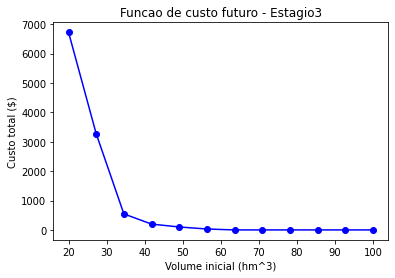

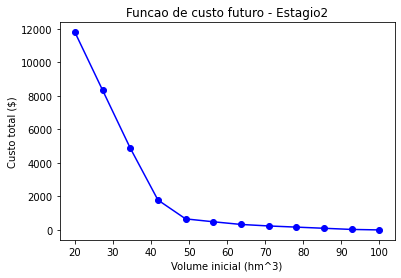

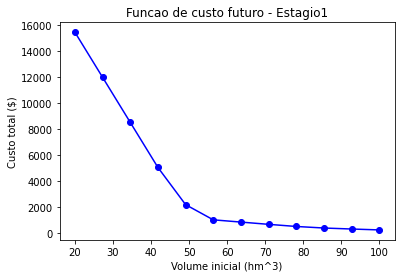

In [ ]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

t = time.time()

Num_UHE = len(sistema["UHE"])

Num_UTE = len(sistema["UTE"])

passo = 100/(sistema["DGer"]["Nr_Disc"]-1)

lista = np.arange(0,100+passo,passo)

discretizacoes = product(lista,repeat=Num_UHE)

discretizacoes = list(discretizacoes)

pote_de_corte = []

for iest in np.arange(sistema["DGer"]["Nr_Est"],0,-1):

  if Num_UHE == 1:
    plt.figure(iest)
    plt.title("Funcao de custo futuro - Estagio"+str(iest))
    plt.xlabel("Volume inicial (hm^3)")
    plt.ylabel("Custo total ($)")

    eixox = []
    eixoy = []

  if Num_UHE == 2:
    fig = plt.figure(iest)
    ax = fig.gca(projection="3d")
    ax.set_title("Funcao de Custo Futuro - Estagio"+str(iest))
    ax.set_xlabel("Vol Ini UHE 1")
    ax.set_ylabel("Vol Ini UHE 2")
    ax.set_zlabel("Custo ($)")
    Usi_1 = np.arange(0,100+passo,passo)
    Usi_2 = np.arange(0,100+passo,passo)
    Usi_1, Usi_2 = np.meshgrid(Usi_1, Usi_2)
    Custos = np.zeros((sistema["DGer"]["Nr_Disc"],sistema["DGer"]["Nr_Disc"]))


  for discretizacao in discretizacoes:
    VI = []

    for i, iusi in enumerate(sistema["UHE"]):
      VI.append(iusi["Vmin"] + (iusi["Vmax"] - iusi["Vmin"])*discretizacao[i]/100)
    
    if Num_UHE == 1:
      eixox.append(VI[0])
    
    media = 0.

    media_cma = []

    for i,iusi in enumerate(sistema["UHE"]):
      media_cma.append(0)

    for icen in np.arange(0,sistema["DGer"]["Nr_Cen"]):
      
      AFL = []

      for i, iusi in enumerate(sistema["UHE"]):
        AFL.append(iusi["Afl"][iest-1][icen])
      
      #print(iest,discretizacao,VI,icen,AFL)
      resultado = despacho(sistema,VI,AFL,pote_de_corte,iest+1,imprime = False)
      media += resultado["DGer"]["Custo total"]

      for i,iusi in enumerate(resultado["UHE"]):
        media_cma[i] += iusi["cma"]


    media = media/sistema["DGer"]["Nr_Cen"]

    if Num_UHE == 2:
      for linha in range(sistema["DGer"]["Nr_Disc"]):
        for coluna in range(sistema["DGer"]["Nr_Disc"]):
          if Usi_1[linha][coluna] == discretizacao[0] and Usi_2[linha][coluna] == discretizacao[1]:
            Custos[linha][coluna] = media

          

    term_indep = media

    for i,iusi in enumerate(resultado["UHE"]):
        media_cma[i] = -media_cma[i]/sistema["DGer"]["Nr_Cen"]
        term_indep -= VI[i]*media_cma[i]

    corte = {
        "Estagio": iest,
        "Termo_Indep": term_indep,
        "Coefs": media_cma
    }

    pote_de_corte.append(corte)

    if Num_UHE == 1:
      eixoy.append(media)

  if Num_UHE == 1:
    plt.plot(eixox,eixoy,marker='o',color="blue")

  if Num_UHE == 2:
    surf = ax.plot_surface(Usi_1,Usi_2,Custos, cmap = cm.coolwarm)


despacho(sistema, [62], [16], pote_de_corte, 2, imprime=True)
#despacho(sistema, [62,150], [16,30], pote_de_corte, 2, imprime=True)  
print("Tempo decorrido na PDE Adaptada",time.time()-t)